## Import

In [1]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'2.0.1+cu118'

In [6]:
# torch.cuda.empty_cache()

## Hyperparameter Setting

In [7]:
CFG = {
    'TRAIN_WINDOW_SIZE':120, # 90일치로 학습  초기는 90일이였음 
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':100,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4096,
    'SEED':41
}

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### 데이터 불러오기

In [9]:
train_data = pd.read_csv('E:/LG/LG_data/train.csv').drop(columns=['ID',"제품"])

In [10]:
brand_keyword_cnt = pd.read_csv('E:/LG/LG_data/brand_keyword_cnt.csv')

# EDA

In [11]:
train_data.head(2)

,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0


In [12]:
train_data.isnull().sum()

대분류           0
중분류           0
소분류           0
브랜드           0
2022-01-01    0
             ..
2023-03-31    0
2023-04-01    0
2023-04-02    0
2023-04-03    0
2023-04-04    0
Length: 463, dtype: int64

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15890 entries, 0 to 15889
Columns: 463 entries, 대분류 to 2023-04-04
dtypes: int64(459), object(4)
memory usage: 56.1+ MB


In [14]:
train_data.describe()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
count,15890.000000,15890.000000,15890.00000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,...,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000
mean,12.887476,10.418880,9.01309,9.190938,11.204216,12.486281,12.933103,12.832599,13.326935,12.049843,...,0.501699,0.483260,0.473694,9.498175,9.370044,7.706293,7.123033,6.975456,9.040340,10.031026
std,183.612376,149.663362,95.82452,86.274138,92.072773,108.478567,135.615709,233.900622,242.761978,242.326264,...,8.853648,8.911203,8.567765,93.854552,90.632349,68.413621,68.629350,59.826757,73.637191,103.256072
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,15056.000000,14320.000000,6064.00000,4470.000000,6370.000000,8210.000000,9712.000000,24512.000000,24032.000000,24960.000000,...,700.000000,660.000000,660.000000,4308.000000,4596.000000,3960.000000,4224.000000,2700.000000,3045.000000,6048.000000


In [15]:
train_data.shape

(15890, 463)

In [16]:
train_data.size

7357070

C:\Users\User\AppData\Local\Temp\ipykernel_9444\589749405.py:24: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\589749405.py:24: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\589749405.py:24: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\589749405.py:24: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\589749405.py:24: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\589749405.py:24: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:\Users\User\

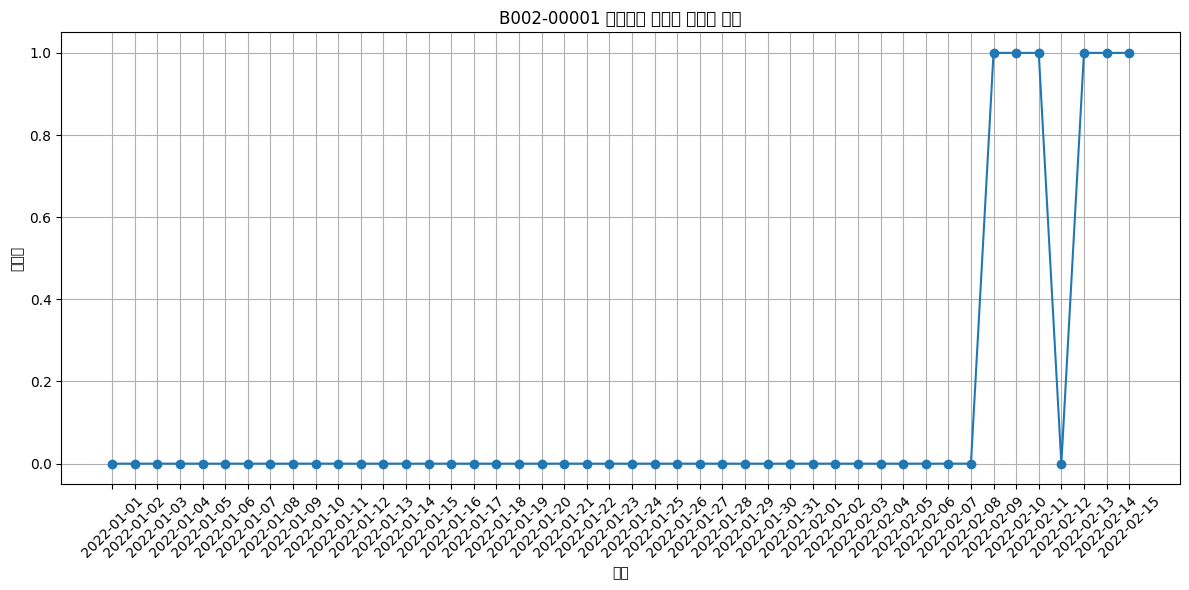

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand = 'B002-00001'  # 분석하려는 브랜드명으로 변경

# 해당 브랜드의 판매량 데이터 추출
brand_sales = train_data[train_data['브랜드'] == target_brand].iloc[:, 4: 50]  # 4번째 열부터 판매량 데이터가 시작됨

# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(brand_sales.columns, brand_sales.values[0], marker='o', linestyle='-')
plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
brand_sales.head()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2022-02-06,2022-02-07,2022-02-08,2022-02-09,2022-02-10,2022-02-11,2022-02-12,2022-02-13,2022-02-14,2022-02-15
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,1,1


In [19]:
brand_sales.values[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1], dtype=int64)

C:\Users\User\AppData\Local\Temp\ipykernel_9444\2464688659.py:29: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\2464688659.py:29: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\2464688659.py:29: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\2464688659.py:29: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\2464688659.py:29: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9444\2464688659.py:29: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:\Users

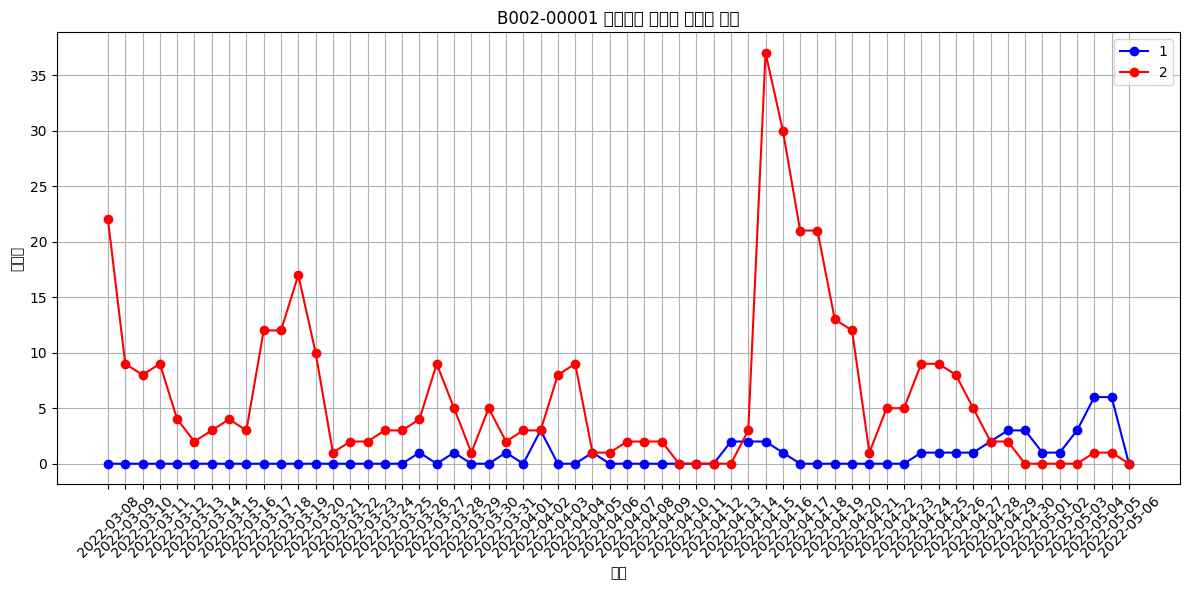

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand_1 = 'B002-00001'  # 분석하려는 브랜드명으로 변경
target_brand_2 = 'B002-00002'
target_brand_2 = 'B002-00003'

# 해당 브랜드의 판매량 데이터 추출
brand_sales_1 = train_data[train_data['브랜드'] == target_brand_1].iloc[:, 70: 130]
brand_sales_2 = train_data[train_data['브랜드'] == target_brand_2].iloc[:, 70: 130]  # 4번째 열부터 판매량 데이터가 시작됨

# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(brand_sales_1.columns, brand_sales_1.values[0], marker='o', linestyle='-', color = 'blue',label = "1")
plt.plot(brand_sales_2.columns, brand_sales_2.values[0], marker='o', linestyle='-', color =  'red', label = "2")
plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
brand_keyword_cnt.head(2)

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.45053,2.42239,1.87119,1.58108,1.23295,1.17493,1.14592,...,0.31911,0.39164,0.37713,0.49318,0.07252,0.29010,0.31911,0.23208,0.33362,0.44966
1,B002-00002,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671


### 데이터 전처리

In [22]:
import pandas as pd

# 더 작은 값을 추가하여 분모가 0인 경우 방지하는 상수 정의
EPSILON = 1e-8

numeric_cols = train_data.columns[4:]

# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)

# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 EPSILON 더해주기
ranges = max_values - min_values + EPSILON

# min-max scaling 수행
scaled_data = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)

# 스케일링된 데이터로 업데이트
train_data[numeric_cols] = scaled_data

# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()


In [23]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [24]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    num_rows = len(data)
    window_size = train_size + predict_size
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :4]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, 4:])
        
        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [25]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :4]) + 1))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

In [26]:
train_data.tail()

,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
15885,2,7,41,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000
15886,2,7,43,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02439,0.0,0.01626,0.03252,0.00813,0.00813,0.024390
15887,2,7,43,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000
15888,2,7,43,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.142857
15889,1,3,19,3169,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.000000


In [27]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

100%|██████████| 15890/15890 [00:17<00:00, 922.94it/s]


In [28]:
data_len = len(train_input)
val_ratio = 0.1
test_ratio = 0.1

val_len = int(data_len * val_ratio)
test_len = int(data_len * test_ratio)

val_input = train_input[-val_len:]
val_target = train_target[-val_len:]

train_input = train_input[:-val_len - test_len]
train_target = train_target[:-val_len - test_len]


In [29]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((4105976, 120, 5),
 (4105976, 21),
 (513247, 120, 5),
 (513247, 21),
 (15890, 120, 5))

### Custom Dataset

In [30]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [31]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

### 모델 선언

# Layer Normalization

In [32]:
# class ImprovedModel(nn.Module):
#     def __init__(self, input_size=5, hidden_size=512, num_layers=2, output_size=CFG['PREDICT_SIZE'], dropout_prob=0.2):
#         super(ImprovedModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
#         self.ln = nn.LayerNorm(hidden_size)  # Layer Normalization
#         self.dropout = nn.Dropout(dropout_prob)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size // 2),
#             nn.ReLU(),
#             nn.Linear(hidden_size // 2, output_size)
#         )
#         self.actv = nn.ReLU()

#     def forward(self, x):
#         batch_size = x.size(0)
#         hidden = self.init_hidden(batch_size, x.device)

#         gru_out, hidden = self.gru(x, hidden)
#         gru_out = self.dropout(gru_out)
#         gru_out = self.ln(gru_out)  # Applying Layer Normalization

#         last_output = gru_out[:, -1, :]

#         output = self.actv(self.fc(last_output))

#         return output.squeeze(1)
#     def init_hidden(self, batch_size, device):
#         return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)



In [33]:
import torch
import torch.nn as nn

class ImprovedModelWithCNN(nn.Module):
    def __init__(self, input_size=5, hidden_size=512, num_layers=2, output_size=CFG['PREDICT_SIZE'], dropout_prob=0.2):
        super(ImprovedModelWithCNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 1D CNN 레이어 추가
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, hidden_size, kernel_size=20, padding=1, stride = 1),  # 1D 합성곱 레이어
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride = 1),  # 맥스 풀링 레이어
            nn.Conv1d(hidden_size, hidden_size, kernel_size=20, padding=1, stride = 1),  # 1D 합성곱 레이어
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride = 1)  # 맥스 풀링 레이어
        )
        
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.ln = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        # 1D CNN 레이어 적용
        x = self.cnn(x.permute(0, 2, 1)).permute(0, 2, 1)

        gru_out, hidden = self.gru(x, hidden)
        gru_out = self.dropout(gru_out)
        gru_out = self.ln(gru_out)  # Layer Normalization 적용

        last_output = gru_out[:, -1, :]

        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)


### 모델 학습

In [34]:
def train(model, optimizer, train_loader, val_loader, device, scheduler=None):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = float('inf')
    best_model = None
    early_stopping_counter = 0
    max_early_stopping = 10  # Max number of consecutive epochs with increasing validation loss
    
    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []
        train_mae = []

        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())


        
        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if scheduler is not None:
            scheduler.step(val_loss)  # Update learning rate based on scheduler's policy
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= max_early_stopping:
                print(f'Early stopping triggered at epoch {epoch}')
                break

    return best_model


In [35]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.mean(val_loss)

## Run !!

In [36]:
import torch.optim.lr_scheduler as lr_scheduler

model = ImprovedModelWithCNN() # BaseModel() 
optimizer = torch.optim.RAdam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.7, verbose=True)
infer_model = train(model, optimizer, train_loader, val_loader, device, scheduler)


100%|██████████| 126/126 [00:36<00:00,  3.44it/s]


Epoch : [1] Train Loss : [0.03141] Val Loss : [0.02979]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [2] Train Loss : [0.03033] Val Loss : [0.02968]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [3] Train Loss : [0.03024] Val Loss : [0.02987]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [4] Train Loss : [0.03020] Val Loss : [0.02984]


100%|██████████| 126/126 [00:35<00:00,  3.54it/s]


Epoch : [5] Train Loss : [0.02983] Val Loss : [0.03003]
Epoch 00005: reducing learning rate of group 0 to 7.0000e-05.


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [6] Train Loss : [0.02899] Val Loss : [0.02985]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [7] Train Loss : [0.02427] Val Loss : [0.02178]


100%|██████████| 126/126 [00:35<00:00,  3.54it/s]


Epoch : [8] Train Loss : [0.02159] Val Loss : [0.02550]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [9] Train Loss : [0.02076] Val Loss : [0.01955]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [10] Train Loss : [0.01997] Val Loss : [0.01904]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [11] Train Loss : [0.01924] Val Loss : [0.02043]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [12] Train Loss : [0.01872] Val Loss : [0.01947]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [13] Train Loss : [0.01841] Val Loss : [0.01793]


100%|██████████| 126/126 [00:35<00:00,  3.56it/s]


Epoch : [14] Train Loss : [0.01802] Val Loss : [0.01798]


100%|██████████| 126/126 [00:35<00:00,  3.50it/s]


Epoch : [15] Train Loss : [0.01785] Val Loss : [0.01801]


100%|██████████| 126/126 [00:35<00:00,  3.55it/s]


Epoch : [16] Train Loss : [0.01761] Val Loss : [0.01717]


100%|██████████| 126/126 [00:35<00:00,  3.54it/s]


Epoch : [17] Train Loss : [0.01729] Val Loss : [0.01723]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [18] Train Loss : [0.01754] Val Loss : [0.01709]


100%|██████████| 126/126 [00:35<00:00,  3.54it/s]


Epoch : [19] Train Loss : [0.01752] Val Loss : [0.01741]


100%|██████████| 126/126 [00:36<00:00,  3.48it/s]


Epoch : [20] Train Loss : [0.01713] Val Loss : [0.01728]


100%|██████████| 126/126 [00:35<00:00,  3.56it/s]


Epoch : [21] Train Loss : [0.01701] Val Loss : [0.01681]


100%|██████████| 126/126 [00:35<00:00,  3.54it/s]


Epoch : [22] Train Loss : [0.01911] Val Loss : [0.01749]


100%|██████████| 126/126 [00:35<00:00,  3.57it/s]


Epoch : [23] Train Loss : [0.01727] Val Loss : [0.01708]


100%|██████████| 126/126 [00:36<00:00,  3.49it/s]


Epoch : [24] Train Loss : [0.01700] Val Loss : [0.01688]
Epoch 00024: reducing learning rate of group 0 to 4.9000e-05.


100%|██████████| 126/126 [00:35<00:00,  3.50it/s]


Epoch : [25] Train Loss : [0.01676] Val Loss : [0.01944]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [26] Train Loss : [0.01677] Val Loss : [0.01680]


100%|██████████| 126/126 [00:35<00:00,  3.56it/s]


Epoch : [27] Train Loss : [0.01668] Val Loss : [0.01682]


100%|██████████| 126/126 [00:35<00:00,  3.52it/s]


Epoch : [28] Train Loss : [0.01663] Val Loss : [0.01665]


100%|██████████| 126/126 [00:35<00:00,  3.50it/s]


Epoch : [29] Train Loss : [0.01652] Val Loss : [0.01764]


100%|██████████| 126/126 [00:36<00:00,  3.49it/s]


Epoch : [30] Train Loss : [0.01650] Val Loss : [0.01727]


100%|██████████| 126/126 [00:35<00:00,  3.57it/s]


Epoch : [31] Train Loss : [0.01645] Val Loss : [0.01675]
Epoch 00031: reducing learning rate of group 0 to 3.4300e-05.


100%|██████████| 126/126 [00:35<00:00,  3.56it/s]


Epoch : [32] Train Loss : [0.01625] Val Loss : [0.01666]


100%|██████████| 126/126 [00:35<00:00,  3.56it/s]


Epoch : [33] Train Loss : [0.01618] Val Loss : [0.01652]


100%|██████████| 126/126 [00:35<00:00,  3.57it/s]


Epoch : [34] Train Loss : [0.01613] Val Loss : [0.01739]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [35] Train Loss : [0.01607] Val Loss : [0.01670]


100%|██████████| 126/126 [00:35<00:00,  3.58it/s]


Epoch : [36] Train Loss : [0.01599] Val Loss : [0.01657]
Epoch 00036: reducing learning rate of group 0 to 2.4010e-05.


100%|██████████| 126/126 [00:35<00:00,  3.51it/s]


Epoch : [37] Train Loss : [0.01586] Val Loss : [0.01670]


100%|██████████| 126/126 [00:35<00:00,  3.57it/s]


Epoch : [38] Train Loss : [0.01581] Val Loss : [0.01801]


100%|██████████| 126/126 [00:35<00:00,  3.58it/s]


Epoch : [39] Train Loss : [0.01577] Val Loss : [0.01671]
Epoch 00039: reducing learning rate of group 0 to 1.6807e-05.


100%|██████████| 126/126 [00:35<00:00,  3.55it/s]


Epoch : [40] Train Loss : [0.01566] Val Loss : [0.01665]


100%|██████████| 126/126 [00:35<00:00,  3.55it/s]


Epoch : [41] Train Loss : [0.01562] Val Loss : [0.01669]


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]


Epoch : [42] Train Loss : [0.01559] Val Loss : [0.01661]
Epoch 00042: reducing learning rate of group 0 to 1.1765e-05.


100%|██████████| 126/126 [00:35<00:00,  3.53it/s]

Epoch : [43] Train Loss : [0.01551] Val Loss : [0.01668]
Early stopping triggered at epoch 43


# 1차 : id, 제품 추가해서 돌리기 시도 - > 2차에 해 볼것은 비슷한 특징 끼리 묶을 생각임 -> 3차 90 일로 줄이고 레이어 늘리고 커널 줄이고시도 

## 모델 추론

In [37]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [38]:
def inference(model, test_loader, device):
    predictions = []
    
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            output = model(X)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
    
    return np.array(predictions)

In [39]:
pred = inference(infer_model, test_loader, device)

100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


In [40]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    
# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [41]:
pred.shape

(15890, 21)

## Submission

In [42]:
submit = pd.read_csv('E:/LG/LG_data/sample_submission.csv')
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
submit.iloc[:,1:] = pred
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,0,0,1,...,1,0,0,0,0,1,1,1,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,4,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [44]:
submit.to_csv('E:/LG/LG_data/models/033_.csv', index=False)